In [59]:
import re
from matplotlib import pyplot as plt
fapp = "400"
with open('singleline_400.ppl') as f:
    lines = f.readlines()

def process_geometry(geometry, n_networks):
    branches = []
    assert "BRANCH" in geometry[0], "Does not start with a BRANCH"
    geometry = '\t'.join(geometry).replace('\n','\t')
    geometry = re.sub(r'\s+', '\t', geometry)
    geometry = geometry.split('BRANCH')
    geometry = [x for x in geometry if x != '']
    assert len(geometry) == n_networks, f"Only {len(geometry)}/{n_networks} found"
    for branch in geometry:
        branch = [x for x in branch.split('\t') if x != '']
        branch_name = branch[0]
        branch_length = int(branch[1])
        branch_values = [float(x) for x in branch[2:]]
        branch_x = branch_values[:branch_length+1]
        branch_elevation = branch_values[branch_length+1:]
        branches.append({
            "name": branch_name,
            "length": branch_length,
            "x": branch_x,
            "elevation": branch_elevation
        })
    return branches
  
    
metadata = lines[:12]
n_networks = int(lines[13])
geometry = lines[15:24]
len_catalog = int(lines[25])
catalog = lines[26:26+len_catalog]
branches = process_geometry(geometry, n_networks)
time_series = lines[44:]
index = 0
series = []
while index < len(time_series):
    time = float(time_series[index])
    index += 1
    values = time_series[index: index+len_catalog]
    series.append({
        'time': time,
        'catalog': catalog,
        'values': [[float(y) for y in x.replace(' \n','').split(' ')] for x in values]
    })
    index += len_catalog
pt_indices = []
qg_indices = []

for i, line in enumerate(catalog):
    if line[:2] == 'PT':
        print(i, line)
        pt_indices.append(i)
for i, line in enumerate(catalog):
    if line[:3] == 'QG ':
        print(i, line)
        qg_indices.append(i)

14 PT 'SECTION:' 'BRANCH:' 'O4P-0_FLOWPATH' '(PA)' 'Pressure'

2 QG 'BOUNDARY:' 'BRANCH:' 'O4P-0_FLOWPATH' '(M3/S)' 'Gas volume flow'



In [61]:
def get_index_by_key(catalog, key):
    indices = []
    for i, line in enumerate(catalog):
        if line[:len(key)+1] == key+' ':
            indices.append(i)
    return indices

keys = [
    'PT',
    'QGST',
    'QWST',
    'QOST',
    'QLTWT',
    'QLTHL'#,
    #'USG',
    #'USLTHL',
    #'USLTWT'
]
i = [1,1,1,1,1,1]#,-1,-1,-1]
for key,position in zip(keys, i):
    indices = get_index_by_key(catalog, key)
    print(key, indices)
    for line_no,branch in zip(indices, branches):
        last = series[-1]
        line = last['values'][line_no]
        print(line[position])

PT [14]
3721705.0
QGST [3]
5.555181
QWST [8]
0.0476182
QOST [6]
0.1111125
QLTWT [5]
0.04773801
QLTHL [4]
0.1179971


'O4P-0_FLOWPATH'


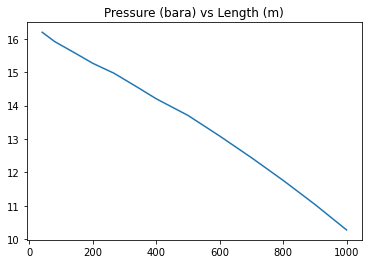

'O4P-0_FLOWPATH'


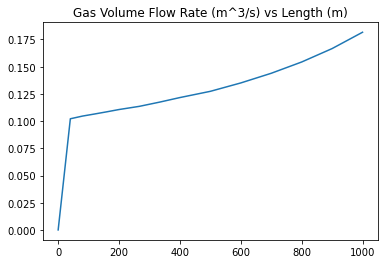

In [42]:
newnames = ("Manifold")

plt.title("Pressure (bara) vs Length (m)")
for branch, pt_index, name in zip(branches, pt_indices, newnames):
    print(branch['name'])
    # print('PT', last['values'][pt_index])
    PT = [x/101325.0 for x in last['values'][pt_index]]
    plt.plot(branch['x'][1:], PT, label=name)
    
#plt.legend()
figname = "PT" + fapp + ".png"
plt.savefig(figname)
plt.show()
plt.title("Gas Volume Flow Rate (m^3/s) vs Length (m)")
for branch, pt_index, qg_index, name in zip(branches, pt_indices, qg_indices, newnames):
    print(branch['name'])
    QG = last['values'][qg_index]
    plt.plot(branch['x'], QG, label=name)
#plt.legend()
figname = "QG" + fapp + ".png"
plt.savefig(figname)
plt.show()
